In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# INSTALL & IMPORT LIBRARY

In [2]:
!pip install underthesea
!pip install transformers
!pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 kB 48.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vn

In [3]:
from bs4 import BeautifulSoup
import numpy as np
import re
# from underthesea import word_tokenize
from keras.utils import to_categorical
from transformers import AutoTokenizer
from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
import pandas as pd

In [4]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.2.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/


--2023-06-24 06:43:44--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412703 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.2.jar’

VnCoreNLP-1.2.jar   100%[===================>]  26.14M   133MB/s    in 0.2s    

2023-06-24 06:43:44 (133 MB/s) - ‘VnCoreNLP-1.2.jar’ saved [27412703/27412703]

--2023-06-24 06:43:44--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

In [5]:
from vncorenlp import VnCoreNLP


In [6]:
def convert_unicode(text):
  char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  char1252 = char1252.split('|')
  charutf8 = charutf8.split('|')

  dic = {}
  for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
  return re.sub(
      r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
      lambda x: dic[x.group()], text
)


In [7]:
class LoadData():
    def __init__(self, file_path):
      self.file_path = file_path

      self.data = pd.read_json(file_path)
      self.data = self.data.fillna(0)
      self.X = []
      self.y = []
    def transform(self,x,label,printed = False):
      def addspace(text):
        text = re.sub(r'([\.\?\/\\\-\+~`#$%!:\"\;\'\|\{\}\[\],])', r' \1 ',text)
        return text

      y = []
      first_index = label[:,0].astype(int)
      second_index = label[:,1].astype(int)
      polars = label[:,2]
      # print(first_index)
      # print(second_index)
      # print("X:",x)
      s = 0
      a = ""
      # chay tu s -> first, cap nhat s
      for i in range(len(label)):

          front = x[s:first_index[i]]
          front = addspace(front)
          # print(first_index[i],second_index[i])
          middle = x[first_index[i]:second_index[i]]
          middle = addspace(middle)

          # print(x)
          # print(middle)
          s = second_index[i]

          a += front + " " + middle + " "
          y.extend(["O" for i in range(len(front.split()))])
          y.extend([f"B-{polars[i]}" if j == 0 else f"I-{polars[i]}" for j in range(len(middle.split()))])

      if s != len(x):
          enc = x[s:]
          enc = addspace(enc)
          a+= enc
          y.extend(["O" for i in range(len(enc.split()))])
      # print(a)
      # for k, v in zip(a.split(),y):
      #     print(k,"=>",v)
      return a,np.array(y)

    def ExtractAspectTermPosition(self,aspectTerms):
        label = []
        # print(aspectTerms)
        for ls in aspectTerms:
            # label.append([int(tag['from']),int(tag['to']),tag['polarity']])
            label.append([int(ls['start']),int(ls['end']),ls['labels'][0]])
        return np.array(sorted(label,key = lambda x: x[0]))

    def load(self,):
        _len = len(self.data)
        for i in range(_len):
            aspect_terms = self.data.iloc[i,2] #label

            x = self.data.iloc[i,0].strip() #text

            if aspect_terms == 0:
              self.X.append(convert_unicode(x))
              self.y.append(['O' for i in range(len(x.split()))])
              continue

            y = self.ExtractAspectTermPosition(aspect_terms)
            if i == 125:
              x,y = self.transform(x,y,True)
            else:
              x,y = self.transform(x,y)
            self.X.append(convert_unicode(x))
            self.y.append(y)

        return self.X,self.y

In [8]:
data_anno1 = LoadData("/content/drive/MyDrive/Đồ án KHDL/dataset/test_300_Quy.json")
a1, anno1 = data_anno1.load()


In [9]:
data_anno2 = LoadData("/content/drive/MyDrive/Đồ án KHDL/dataset/test_300_Van.json")
a2, anno2 = data_anno2.load()

In [10]:
for z in range(len(a1)):
  if len(anno1[z]) != len(anno2[z]):
    print(z)

In [11]:
tag2idx = {"O":1,"B-Positive":2,"B-Neutral":3,"B-Negative":4,"B-Conflict":5,"I-Positive":6,"I-Neutral":7,"I-Negative":8,"I-Conflict":9}
idx2tag = {v:k for k,v in tag2idx.items()}

In [12]:
def convert_num(annot):
  an = []
  for i in range(len(annot)):
    an.extend(list(map(lambda x:tag2idx[x],annot[i])))
  return an
annot_1 = convert_num(anno1[:300])
annot_2 = convert_num(anno2[:300])

In [13]:
annot_1_0_100 = convert_num(anno1[0:100])
annot_1_100_200 = convert_num(anno1[100:200])
annot_1_200_300 = convert_num(anno1[200:300])

In [14]:
annot_2_0_100 = convert_num(anno2[0:100])
annot_2_100_200 = convert_num(anno2[100:200])
annot_2_200_300 = convert_num(anno2[200:300])


In [15]:
from sklearn.metrics import cohen_kappa_score
kappa_phase_1 = cohen_kappa_score(annot_1_0_100, annot_2_0_100)
kappa_phase_2 = cohen_kappa_score(annot_1_100_200, annot_2_100_200)
kappa_phase_3 = cohen_kappa_score(annot_1_200_300, annot_2_200_300)

In [16]:
from sklearn.metrics import f1_score
f1_phase_1 = f1_score(annot_1_0_100, annot_2_0_100,average = 'macro')
f1_phase_2 = f1_score(annot_1_100_200, annot_2_100_200,average = 'macro')
f1_phase_3 = f1_score(annot_1_200_300, annot_2_200_300,average = 'macro')

In [17]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(annot_1, annot_2)

0.8701363430113002

In [18]:
from sklearn.metrics import f1_score
f1_score(annot_1,annot_2,average = 'macro')

0.8346136723317222

In [ ]:

data_dis = pd.DataFrame({"set":["train","train","train","dev","dev","dev","test","test","test"],"sentiment polarity":["Positive","Neutral","Negative","Positive","Neutral","Negative","Positive","Neutral","Negative"],"value":[8860,4480,1084,2265,1077,257,1394,1031,189]})
data_dis

,set,sentiment polarity,value
0,train,Positive,8860
1,train,Neutral,4480
2,train,Negative,1084
3,dev,Positive,2265
4,dev,Neutral,1077
5,dev,Negative,257
6,test,Positive,1394
7,test,Neutral,1031
8,test,Negative,189


<Figure size 2500x2500 with 0 Axes>

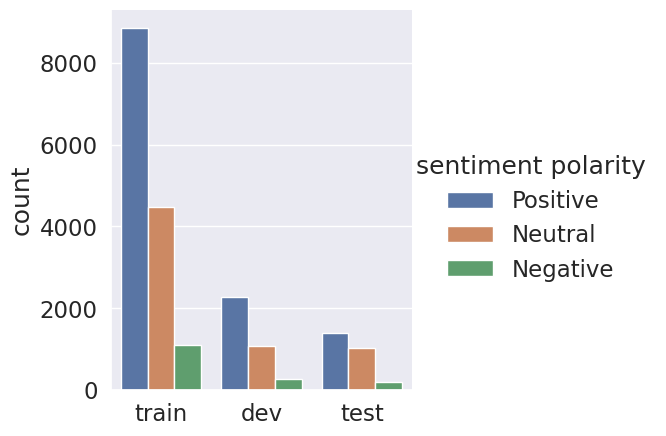

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.5)
plt.figure(figsize = (25,25))

g = sns.catplot(
    data=data_dis, kind="bar",
    x="set", y="value", hue="sentiment polarity",
)
g.set_axis_labels("", "count")


In [19]:
data = pd.DataFrame({"phase":["Phase 3","Phase 2","Phase 1"], "type":["F1-measure","F1-measure","F1-measure"],"value":[f1_phase_1,f1_phase_2,f1_phase_3]})
data.sort_values('value')

,phase,type,value
2,Phase 1,F1-measure,0.819624
1,Phase 2,F1-measure,0.843600
0,Phase 3,F1-measure,0.843959


<Figure size 2500x2500 with 0 Axes>

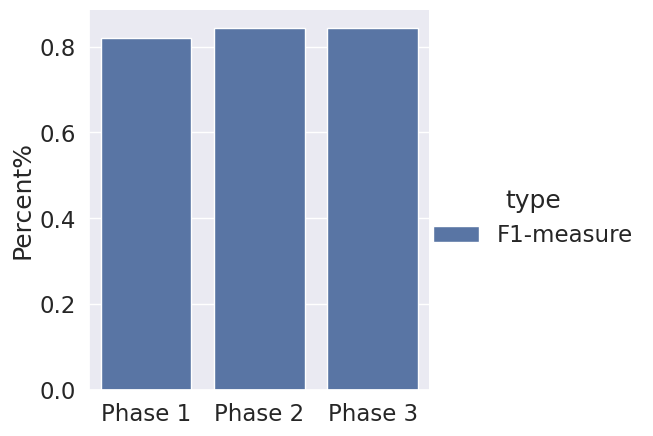

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.5)
plt.figure(figsize = (25,25))

g = sns.catplot(
    data=data.sort_values('value'), kind="bar",
    x="phase", y="value", hue="type",
)
g.set_axis_labels("", "Percent%")


In [ ]:
data = pd.read_json("/content/drive/MyDrive/Đồ án KHDL/dataset/data.json")

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_dev = train_test_split(data,test_size=0.2,random_state = 42)

In [ ]:
X_train.shape,X_dev.shape

((3288, 8), (822, 8))

In [ ]:
X_train['text'].apply(lambda x: len(x.split())).mean()

50.03375912408759

In [ ]:
X_dev['text'].apply(lambda x: len(x.split())).mean()

50.58029197080292

In [ ]:
X_train = X_train.dropna()
X_dev = X_dev.dropna()

In [ ]:
count_dic = {"Neutral":0,"Positive":0,"Negative":0,"Conflict":0}
for i in range(X_train.shape[0]):
  labels = X_train.iloc[i,2]
  for j in range(len(labels)):
    count_dic[labels[j]['labels'][0]] += 1
print("train")
count_dic,sum(count_dic.values())

train


({'Neutral': 4480, 'Positive': 8860, 'Negative': 1084, 'Conflict': 264}, 14688)

In [ ]:
count_dic = {"Neutral":0,"Positive":0,"Negative":0,"Conflict":0}
for i in range(X_dev.shape[0]):
  labels = X_dev.iloc[i,2]
  for j in range(len(labels)):
    count_dic[labels[j]['labels'][0]] += 1
print("dev")
count_dic,sum(count_dic.values())

dev


({'Neutral': 1077, 'Positive': 2265, 'Negative': 257, 'Conflict': 86}, 3685)

In [ ]:
test = pd.read_json("/content/drive/MyDrive/Đồ án KHDL/dataset/test_300_Quy.json")
test = test.dropna()

In [ ]:
count_dic = {"Neutral":0,"Positive":0,"Negative":0,"Conflict":0}
for i in range(test.shape[0]):
  labels = test.iloc[i,2]
  for j in range(len(labels)):
    count_dic[labels[j]['labels'][0]] += 1
print("test")
count_dic,sum(count_dic.values())

test


({'Neutral': 1031, 'Positive': 1394, 'Negative': 189, 'Conflict': 30}, 2644)

In [ ]:
test['text'].apply(lambda x: len(x.split())).mean()

109.46979865771812